## 1. Prepare Environments

* 데이터 폴더의 경로를 설정합니다.
* 필요한 라이브러리를 import 합니다.

In [ ]:
### 한국어 설치 apt-get install에서 Error 발생 시, 'sudo' 명령어 추가해서 root 권한으로 실행.
# !apt-get install fonts-nanum*
# !fc-cache -fv

In [ ]:
# utils
import os
from dotenv import load_dotenv
import copy
import time
import logging
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',None) # 또는 숫자 지정
pd.set_option('display.max_columns',None)

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일 저장 경로
    name='NanumBarunGothic' # 별칭
)
fm.fontManager.ttflist.insert(0,fe)
plt.rcParams.update({'font.family' : 'NanumBarunGothic'}) # 한글 패치
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False # 음수 부호 안 깨지게

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn.init as init

# Image Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from augraphy import *

### random seed 고정 함수
def set_seed(seed: int = 42):
    """모든 랜덤 시드를 고정합니다.

    :param int seed: 고정할 시드 값, defaults to 42
    """
    random.seed(seed)
    np.random.seed(seed)

    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 멀티 GPU용
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass  # torch가 설치되어 있지 않으면 무시

In [2]:
print("현재 jupyter notebook의 실행 경로:", os.getcwd())

현재 jupyter notebook의 실행 경로: /data/ephemeral/home/upstageailab-cv-classification-cv_5/codes/practice


In [3]:
timm.list_models(filter="resnet*", pretrained=True)

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_in1k',
 'resnet26d.bt_in1k',
 'resnet26t.ra2_in1k',
 'resnet32ts.ra2_in1k',
 'resnet33ts.ra2_in1k',
 'resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k',
 'resnet34.tv_in1k',
 'resnet34d.ra2_in1k',
 'resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k',
 'resnet50_gn.a1h_in1k',
 'resnet50c.gluon_in1k',
 'resnet50d.a1_in1k',
 '

In [4]:
project_root = '/data/ephemeral/home/upstageailab-cv-classification-cv_5'
data_dir = os.path.join(project_root, 'data')
print("⚙️ Data Directory Path:", data_dir)

device = 'cpu'
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
print("⚙️ Device :",device)

from zoneinfo import ZoneInfo
from datetime import datetime
CURRENT_TIME = datetime.now(ZoneInfo("Asia/Seoul")).strftime("%y%m%d%H%M")
print(f"⌚ 실험 시간: {CURRENT_TIME}")

CFG = {
    'model_name': 'efficientvit_m5.r224_in1k', # timm model name
    'pretrained': True, # timm pretrained 가중치 사용 여부
    'fine_tuning': "scratch", # fine-tuning 방법론
    # full : pretrained=True, pretrained가중치를 전부 재학습시킨다. 
    # head : pretrained=True, model backbone 부분은 freeze하고 head 부분을 재학습시킨다.
    # custom : pretrained=True, backbone에서도 일부분을 재학습시킨다.
    # scratch : pretrained=False, 모델 구조만 사용하고 모든 가중치를 처음부터 학습시킨다.
    # Loss Function
    'criterion': 'CrossEntropyLoss',
    # optimizer name: SGD, RMSprop, Momentum, NAG, Adam, AdamW, NAdam, RAdam, Adafactor
    # reference : https://www.notion.so/skier-song9/Pytorch-9cfee0520ed6468a94b024ea35e48018?source=copy_link#217c8d3f60f58044beeac55596433dc6
    'optimizer_name': 'AdamW', 
    'lr': 1e-2, # learning rate
    'weight_decay': 1e-4, # weight decay ratio
    # scheduler_name : StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR, ReduceLROnPlateau
    # reference : https://www.notion.so/skier-song9/Pytorch-9cfee0520ed6468a94b024ea35e48018?source=copy_link#1d2c8d3f60f58026b71ad399ead029a9
    'scheduler_name': 'OneCycleLR',
    
    # 기타 변수들
    'random_seed': 256, 
    'n_folds': 5, # validation set, cross-validation 시 fold의 개수
    'val_split_ratio': 0.15, # train-val split 비율
    'stratify': True, # validation set 분할 시 stratify 전략 사용 여부
    'image_size': 224, # 만약 multi-scale train/test 시 None으로 설정

    # normalization mean, std
    # full file tuning 시 0.5가 유리
    # pre-trained 모델 사용 시 pre-trained 모델의 mean, std를 사용
    'norm_mean': [0.5, 0.5, 0.5],
    'norm_std': [0.5, 0.5, 0.5],

    # 적용하는 기법들 명시
    'augmentation': {},

    # 모델에 대한 hyperparameters
    'model_layer': {}, # model layer의 filter size, activation function, pooling layer 등 변경 시 작성
    'dropout': 0.3, # model layer에서 dropout 비율 변경 시 작성
    'timm_activation': "ReLU",
    'activation': "SELU", # ReLU, LeakyReLU, ELU, SELU, GELU, Tanh, PReLU, SiLU

    # 학습 시 hyperparameters
    'epochs': 10000, # max epoch
    'patience': 50, # early stopping patience
    'batch_size': 64,

    # device
    'device': device # device name
}
if CFG['patience'] < 5:
    raise ValueError("Ealry stopping patience must be larger than 5!")

# wandb setting
import wandb
wandb.login()
# 로그 레벨을 WARNING 이상으로 설정하여 wandb 메시지를 억제
wandb.setup()  # Optional, sets up environment
wandb.termlogger.setLevel(logging.WARNING)
wandb.termlogger.setLevel(logging.WARNING)
WB = False # wandb 기록할 거면 True, 아니면 False.
project_name = "upstage-img-clf"
# def get_runs(project_name):
#     # wandb project의 runs들을 가져옴
#     return wandb.Api().runs(path=project_name, order="-created_at")
# def get_latest_run(project_name):
#     runs = get_runs(project_name) # wandb project의 runs들을 가져옴
#     if not runs: # 최초 runs에는 project_name-001 로 이름을 만든다.
#         return f"{CFG['model_name']}-opt_{CFG['optimizer_name']}-img{CFG['image_size']}-aug_{len(CFG['augmentation'])}-{CURRENT_TIME}-0000"
#     return runs[0].name # 가장 최근의 runs 이름을 가져온다.
# def auto_increment_run_suffix(name: str, pad=4):
#     suffix = name.split("-")[-1]
#     next_suffix = str(int(suffix) + 1).zfill(pad) # 2 > 0002
#     return name.replace(suffix, next_suffix)
# recent_run_name = get_latest_run(project_name)
# next_run_name = auto_increment_run_suffix(recent_run_name) # 가장 최근 runs의 숫자를 1 올린다.
next_run_name = f"{CURRENT_TIME}-{CFG['model_name']}-opt_{CFG['optimizer_name']}-img{CFG['image_size']}-aug_{len(CFG['augmentation'])}"
print(f"📢 run name: {next_run_name}")
run = None
if WB:
    run = wandb.init(
        project=project_name,
        name=next_run_name,
        config=CFG
    )
    pass

# transform dictionary into namespace
from types import SimpleNamespace
CFG = SimpleNamespace(**CFG)

# set random seed
set_seed(CFG.random_seed)

⚙️ Data Directory Path: /data/ephemeral/home/upstageailab-cv-classification-cv_5/data
⚙️ Device : cuda
⌚ 실험 시간: 2507010327


wandb: Currently logged in as: skiersong9 (skiersong) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


📢 run name: resnetrs101.tf_in1k-opt_Adam-img224-aug_0-2507010210-0002


In [5]:
# download data
# os.chdir(project_root)
# !wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000356/data/data.tar.gz
# !tar -zxvf data.tar.gz

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [6]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    # def __init__(self, csv, path, transform=None):
    def __init__(self, df:pd.DataFrame, path, transform=None):
        """
        :param pd.DataFrame df: train-val을 위해서는 pandas.Dataframe으로 받아야 함.
        :param str path: 이미지 데이터 디렉토리 경로
        :param _type_ transform: 이미지 변형, defaults to None
        """
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [7]:
import copy

class EarlyStopping:
	def __init__(self, patience=5, min_delta=1e-6, restore_best_weights=True):
		self.patience = patience
		self.min_delta = min_delta
		self.restore_best_weights = restore_best_weights
		self.best_model_state_dict = None
		self.best_loss = None
		self.counter = 0
		self.status = ""
	
	def __call__(self, model, val_loss):
		if self.best_loss is None:
			#현재의 모델로 self.best_loss, self.best_model_state_dict 업데이트
			self.best_loss = val_loss
			self.best_model_state_dict = copy.deepcopy(model.state_dict())
		elif val_loss < self.best_loss - self.min_delta:
			#val_loss가 best_loss보다 좋을 때 > self.best_loss와 self.best_model 업데이트
			self.best_model_state_dict = copy.deepcopy(model.state_dict())
			self.best_loss = val_loss
			self.counter = 0
			self.status = f"Improvement found, counter reset to {self.counter}"
		else:
			#val_loss가 더 안 좋을 때 > patience 증가하고 early stop 여부 확인
			self.counter += 1
			self.status = f"No improvement in the last {self.counter} epochs"
			if self.counter >= self.patience: # ealy stop
				self.status = f"Early stopping triggered after {self.counter} epochs."
				if self.restore_best_weights and self.best_model_state_dict is not None:
					model.load_state_dict(self.best_model_state_dict)
					return True
		return False # end with no early stop
	
	def restore_best(self, model):
		if self.best_loss is not None and self.best_model_state_dict is not None:
			print(f"Restore model_state_dict of which best_loss: {self.best_loss:.6f}")
			model.load_state_dict(self.best_model_state_dict)
			return True
		return False

class TrainModule():
	def __init__(self, model: torch.nn.Module, criterion, optimizer, scheduler, train_loader, valid_loader, cfg: SimpleNamespace, verbose:int =50, run=None):
		'''
		model, criterion, scheduler, train_loader, valid_loader 미리 정의해서 전달
		cfg : es_patience, epochs 등에 대한 hyperparameters를 namespace 객체로 입력
		'''
		required_attrs = ['scheduler_name','patience', 'epochs']
		for attr in required_attrs:
			assert hasattr(cfg, attr), f"AttributeError: There's no '{attr}' attribute in cfg."
		assert verbose > 1 and verbose < cfg.epochs, f"Logging frequency({verbose}) MUST BE smaller than EPOCHS({cfg.epochs}) and positive value."
		
		self.model = model
		self.criterion = criterion
		self.optimizer = optimizer
		self.scheduler = scheduler
		self.train_loader = train_loader
		self.valid_loader = valid_loader
		self.cfg = cfg
		if getattr(cfg, "device", False):
			self.model.to(self.cfg.device)
		else:
			self.cfg.device = 'cpu'
		self.es = EarlyStopping(patience=self.cfg.patience)
		### list for plot
		self.train_losses_for_plot, self.val_losses_for_plot = [], []
		self.train_acc_for_plot, self.val_acc_for_plot = [], [] # classification
		self.train_f1_for_plot, self.val_f1_for_plot = [], [] # classification
		# logging frequency
		self.verbose = verbose
		# wandb run object
		self.run = run
		
	def training_step(self):
		# set train mode
		self.model.train()
		running_loss = 0.0
		correct = 0 # classification
		total = 0
		all_preds = []
		all_targets = []
		
		for train_x, train_y in self.train_loader: # batch training
			train_x, train_y = train_x.to(self.cfg.device), train_y.to(self.cfg.device)
			
			self.optimizer.zero_grad() # 이전 gradient 초기화
			outputs = self.model(train_x)
			loss = self.criterion(outputs, train_y)
			
			loss.backward() # backward pass
			self.optimizer.step() # 가중치 업데이트
			if self.cfg.scheduler_name == "OneCycleLR":
				self.scheduler.step()
			
			running_loss += loss.item() * train_y.size(0) # train_loss 
			_, predicted = torch.max(outputs, 1) # 가장 확률 높은 클래스 예측 # classification
			correct += (predicted == train_y).sum().item() # classification
			total += train_y.size(0) 

			all_preds.extend(predicted.cpu().numpy())
			all_targets.extend(train_y.cpu().numpy())
			
		epoch_loss = running_loss / total # average loss of 1 epoch
		epoch_acc = 100 * correct / total # classification
		epoch_f1 = f1_score(all_targets, all_preds, average='macro') # classification
		return epoch_loss, epoch_acc, epoch_f1  # classification		
	
	def validation_step(self):
		self.model.eval()  # 평가 모드
		val_loss = 0
		correct = 0 # classification
		total = 0
		all_preds = []
		all_targets = []
		
		with torch.no_grad():  # gradient 계산 비활성화
			for val_x, val_y in self.valid_loader: # batch training
				val_x, val_y = val_x.to(self.cfg.device), val_y.to(self.cfg.device)
				
				outputs = self.model(val_x)
				loss = self.criterion(outputs, val_y)
								
				val_loss += loss.item() * val_y.size(0)
				_, predicted = torch.max(outputs, 1) # classification
				correct += (predicted == val_y).sum().item() # classification
				total += val_y.size(0)

				all_preds.extend(predicted.cpu().numpy())
				all_targets.extend(val_y.cpu().numpy())
		
		epoch_loss = val_loss / total # average loss of 1 epoch
		epoch_acc = 100 * correct / total # classification
		epoch_f1 = f1_score(all_targets, all_preds, average='macro') # classification
		return epoch_loss, epoch_acc, epoch_f1 # classification
	
	def training_loop(self):
		try:
			# reset loss list for plots
			self.train_losses_for_plot, self.val_losses_for_plot = [], []
			self.train_acc_for_plot, self.val_acc_for_plot = [], []
			epoch_counter = 0
			epoch_timer = []
			done = False
			
			pbar = tqdm(total=self.cfg.epochs)
			while not done and epoch_counter<self.cfg.epochs:
				st = time.time()
				epoch_counter += 1
				
				# train
				# train_loss = self.training_step() # regression
				train_loss, train_acc, train_f1 = self.training_step() # classification
				
				self.train_losses_for_plot.append(train_loss)
				self.train_acc_for_plot.append(train_acc) # classification
				self.train_f1_for_plot.append(train_f1) # classification
				
				# validation
				# val_loss = self.validation_step() # regression
				val_loss, val_acc, val_f1 = self.validation_step()  # classification
				self.val_losses_for_plot.append(val_loss)
				self.val_acc_for_plot.append(val_acc) # classification
				self.val_f1_for_plot.append(val_f1) # classification

				
				# scheduler의 종류에 따라 val_loss를 전달하거나 그냥 step() 호출.
				if self.cfg.scheduler_name == "OneCycleLR":
					pass
				elif self.cfg.scheduler_name == "ReduceLROnPlateau":
					self.scheduler.step(val_loss)
				else:
					self.scheduler.step()
				epoch_timer.append(time.time() - st)
				pbar.update(1)
				if self.es(self.model, val_loss):
					# early stopped 된 경우 if 문 안으로 들어온다.
					done = True
				if self.run is not None:
					print('wandb logging...')
					epoch_log = {
						'train_loss': train_loss,
						'train_accuracy': train_acc,
						'train_f1': train_f1,
						'val_loss': val_loss,
						'val_accuracy': val_acc,
						'val_f1': val_f1
					}
					run.log(epoch_log, step=epoch_counter) # wandb logging
				if epoch_counter == 1 or epoch_counter % self.verbose == 0:
					# self.verbose epoch마다 logging
					mean_time_spent = np.mean(epoch_timer)
					epoch_timer = [] # reset timer list
					# print(f"Epoch {epoch_counter}/{self.cfg.epochs} [Time: {mean_time_spent:.2f}s], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}")
					print(f"Epoch {epoch_counter}/{self.cfg.epochs} [Time: {mean_time_spent:.2f}s], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}\n Train ACC: {train_acc:.2f}%, Validation ACC: {val_acc:.2f}%\n Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}") # classification
		except Exception as e:
			print(e)
			return False # training loop failed
		return True # training loop succeed
		
	def plot_loss(self, show:bool=False, savewandb:bool=True, savedir:str=None):
		"""loss, accuracy, f1-score에 대한 그래프 시각화 함수

		:param bool show: plt.show()를 실행할 건지, defaults to False
		:param bool savewandb: wandb logging에 plot을 시각화하여 저장할 건지, defaults to True
		:param str savedir: plot을 저장할 디렉토리를 설정, None이면 저장 안 함, defaults to None
		:return _type_: None
		"""
		import matplotlib.pyplot as plt
		fig, ax = plt.subplots(figsize=(6, 4))
		plt.plot(range(len(self.train_losses_for_plot)),self.train_losses_for_plot,color='blue',label='train_loss')
		plt.plot(range(len(self.val_losses_for_plot)),self.val_losses_for_plot,color='red',label='val_loss')
		plt.axhline(y=1e-3, color='red', linestyle='--', label='(Overfit)')
		plt.legend()
		plt.xlabel("Epoch")
		plt.ylabel("Loss")
		plt.title("Train/Validation Loss plot")
		if savedir is not None:
			if os.path.exists(savedir):
				os.makedirs(savedir, exist_ok=True)
			savepath = os.path.join(savedir, "loss_plot.png")
			plt.savefig(savepath)
			print(f"⚙️loss plot saved in {savepath}")
		if show:
			plt.show()
		if savewandb and self.run is not None:
			run.log({'loss_plot': wandb.Image(fig)}) # wandb
		plt.clf()
		
		# classification
		fig, ax = plt.subplots(figsize=(6, 4))
		plt.plot(range(len(self.train_acc_for_plot)),self.train_acc_for_plot,color='blue',label='train_acc')
		plt.plot(range(len(self.val_acc_for_plot)),self.val_acc_for_plot,color='red',label='val_acc')
		plt.axhline(y=99.0, color='red', linestyle='--', label='(99%)')
		plt.legend()
		plt.xlabel("Epoch")
		plt.ylabel("Accuracy(%)")
		plt.title("Train/Validation Accuracy Plot")
		plt.grid()
		if savedir is not None:
			savepath = os.path.join(savedir, "accuracy_plot.png")
			plt.savefig(savepath)
			print(f"⚙️accuracy plot saved in {savepath}")
		if show:
			plt.show()
		if savewandb and self.run is not None:
			run.log({'accuracy_plot': wandb.Image(fig)}) # wandb
		plt.clf()

		# classification
		fig, ax = plt.subplots(figsize=(6, 4))
		plt.plot(range(len(self.train_f1_for_plot)),self.train_f1_for_plot,color='blue',label='train_f1')
		plt.plot(range(len(self.val_f1_for_plot)),self.val_f1_for_plot,color='red',label='val_f1')
		plt.axhline(y=0.99, color='red', linestyle='--', label='(0.99)')
		plt.legend()
		plt.xlabel("Epoch")
		plt.ylabel("F1-score")
		plt.title("Train/Validation F1-score Plot")
		plt.grid()
		if savedir is not None:
			savepath = os.path.join(savedir, "f1_plot.png")
			plt.savefig(savepath)
			print(f"⚙️f1 plot saved in {savepath}")
		if show:
			plt.show()
		if savewandb and self.run is not None:
			run.log({'f1_plot': wandb.Image(fig)}) # wandb
		plt.clf()
		return None
		
	def save_experiments(self, savepath=None):
		""""""
		save_dict = {
			'model_state_dict': self.model.state_dict(),
			'optimizer_state_dict': self.optimizer.state_dict(),
			'scheduler_state_dict': self.scheduler.state_dict(),
			'cfg': vars(self.cfg) # 나중에 로드해서 CFG = SimpleNamespace(**cfg)로 복원
		}
		if savepath is not None:
			dirpath = os.path.dirname(savepath)
			if os.path.exists(dirpath):
				os.makedirs(dirpath, exist_ok=True)
			torch.save(save_dict, f=savepath)
			return True
		return False
		

## 3. Load Data & Augmentation
* 학습, 테스트 데이터셋과 로더를 정의합니다.
* 이미지 증강 기법을 정의합니다.

> references   
> - torchvision 직접 구현 : [예시 코드](https://skier-song9.notion.site/CustomDataset-Augmentation-1d1c8d3f60f58026b4def1895f3fb9b0?source=copy_link)   
> - Albumentation : [예시 코드](https://albumentations.ai/docs/examples/)   
> - Augraphy : [예시 코드](https://augraphy.readthedocs.io/en/latest/doc/source/example_usage.html), [PyTorch 프로세스에서 사용 방법](https://augraphy.readthedocs.io/en/latest/examples/pytorch_integration_classification_example.html)

In [8]:
def apply_augraphy(image, **kwargs):
    """_summary_

    :param _type_ image: _description_
    :return _type_: _description_
    """
    # augraphy는 uint8, BGR 순서의 이미지 사용
    image = np.array(image)
    aug_image = AugraphyPipeline(image)
    return {"image": aug_image}

def build_augraphy_pipeline():
    ink_phase = [Dithering(p=0.5),
        InkBleed(p=0.5),
        OneOf([LowInkRandomLines(p=1), LowInkPeriodicLines(p=1)]),
    ]
    paper_phase = [ColorPaper(p=0.5)]
    post_phase = [Markup(p=0.25),
        DirtyRollers(p=0.25),
        Scribbles(p=0.25),
        BindingsAndFasteners(p=0.25),
        BadPhotoCopy(p=0.25),
        DirtyDrum(p=0.25),
    ]
    pipeline = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)
    return pipeline

def build_train_transform(cfg):
    """_summary_

    :param _type_ cfg: _description_
    :return _type_: _description_
    """
    transform_list = []
    if cfg.augmentation.get('augraphy'):
        transform_list.append(A.Lambda(image=apply_augraphy, always_apply=True))
    return A.Compose(transform_list)

In [9]:
# augmentation을 위한 transform 코드
train_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=CFG.image_size, width=CFG.image_size),
    # images normalization
    A.Normalize(mean=CFG.norm_mean, std=CFG.norm_std),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# valid, test image 변환을 위한 transform 코드
test_transform = A.Compose([
    A.Resize(height=CFG.image_size, width=CFG.image_size),
    A.Normalize(mean=CFG.norm_mean, std=CFG.norm_std),
    ToTensorV2(),
])

#### Train-Validation 분할

In [10]:
# train-validation split
### TO-DO
from sklearn.model_selection import train_test_split
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
train_idx, val_idx = train_test_split(
    range(len(train_df)),
    test_size=CFG.val_split_ratio,
    stratify=train_df['target'],
    shuffle=True,
    random_state=CFG.random_seed
)
print(len(train_idx), len(val_idx))

# Create train and validation CSV files temporarily
train_subset = train_df.iloc[train_idx].reset_index(drop=True)
val_subset = train_df.iloc[val_idx].reset_index(drop=True)


1334 236


#### Dataset 및 DataLoader 정의

In [11]:
# Dataset 정의
train_dataset = ImageDataset(
    train_subset,
    os.path.join(data_dir, "train"),
    transform=train_transform
)
# ImageDataset의 df 속성을 train_subset으로 업데이트
train_dataset.df = train_subset

valid_dataset = ImageDataset(
    val_subset,
    os.path.join(data_dir, "train"),
    transform=test_transform
)
# ImageDataset의 df 속성을 val_subset으로 업데이트
valid_dataset.df = val_subset

test_dataset = ImageDataset(
    pd.read_csv(os.path.join(data_dir, "sample_submission.csv")),
    os.path.join(data_dir, "test"),
    transform=test_transform
)
print(len(train_dataset), len(valid_dataset), len(test_dataset))

1334 236 3140


In [12]:
# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [13]:
for train_x, train_y in train_loader:
    print(train_x.shape)
    break

torch.Size([64, 3, 224, 224])


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [14]:
def get_activation(CFG):
    ACTIVATIONS = {
        'ReLU': nn.ReLU, # 음수는 0으로, 양수는 선형함수
        'LeakyReLU': nn.LeakyReLU, # 음수도 일부 통과 -> Dead ReLU 방지
        'ELU': nn.ELU, # 음수도 일부 통과 → 출력 평균이 0에 가깝도록 함으로써 학습 안정화 도움
        'SELU': nn.SELU, # ELU에 스케일링 계수를 곱해 신경망을 자기 정규화, 특정 조건 (예: fully connected, 특정 초기화, 특정 구조)에서만 자기 정규화 효과가 잘 발휘
        'GELU': nn.GELU, # 더 부드러운 비선형성, Transformer, BERT류
        'Tanh': nn.Tanh, # 완만한 sigmoid
        'PReLU': nn.PReLU, # 음수도 일부 통과 -> Dead ReLU 방지, 기울기를 학습함.
        'SiLU': nn.SiLU, # 더 부드러운 비선형성, EfficientNet, Swin Transformer 등
    }
    return ACTIVATIONS[CFG.activation]

class TimmWrapper(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.backbone = timm.create_model(
            model_name=CFG.model_name,
            pretrained=CFG.pretrained,
            num_classes=0, global_pool='avg'
        )
        self.dropout = nn.Dropout(p=CFG.dropout)
        self.activation = get_activation(CFG)()
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 1000),
            nn.BatchNorm1d(1000),
            self.activation,
            self.dropout,
            nn.Linear(1000, 17)
        )
        def weight_init(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if CFG.timm_activation in ['Tanh']:
                    # Xavier 초기화
                    init.xavier_uniform_(m.weight)
                else:
                    # He 초기화
                    init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
        if CFG.fine_tuning == 'head':
            # backbone 파라미터를 freeze
            for param in self.backbone.parameters():
                param.requires_grad = False
            # classifier는 가중치 초기화
            self.classifier.apply(weight_init)
        elif CFG.fine_tuning == 'custom':
            # 직접 커스터마이징
            pass
        elif CFG.fine_tuning == 'scratch':
            self.apply(weight_init)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

def get_timm_model(CFG):
    if CFG.dropout is not None:
        return TimmWrapper(CFG).to(CFG.device)

    return timm.create_model(
        CFG.model_name,
        pretrained=CFG.pretrained,
        num_classes=17,
        act_layer=CFG.timm_activation # activation function 설정 (pretrained=True라면 pretrained의 activation을 그대로 사용하는 것이 좋다.)
    ).to(CFG.device)

def get_criterion(CFG):
    CRITERIONS = {
        "CrossEntropyLoss" : nn.CrossEntropyLoss()
    }
    return CRITERIONS[CFG.criterion]

def get_optimizers(model, CFG):
    # SGD, RMSprop, Momentum, NAG, Adam, AdamW, NAdam, RAdam, Adafactor
    OPTIMIZERS = {
        'SGD': optim.SGD(model.parameters(), lr=CFG.lr),
        'RMSprop': optim.RMSprop(model.parameters(), lr=CFG.lr, alpha=0.99, weight_decay=CFG.weight_decay),
        'Momentum': optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9),
        'NAG' : optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True),
        'Adam' : optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay),
        'AdamW': optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay),
        'NAdam': optim.NAdam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, momentum_decay=4e-3),
        'RAdam': optim.RAdam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay),
        'Adafactor': optim.Adafactor(model.parameters(), lr=CFG.lr, beta2_decay=-0.8, d=1.0, weight_decay=CFG.weight_decay, maximize=False)
    }
    return OPTIMIZERS[CFG.optimizer_name]

def get_scheduler(optimizer, CFG):
    # StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR, ReduceLROnPlateau
    SCHEDULERS = {
        'StepLR': lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1),
        'ExponentialLR': lr_scheduler.ExponentialLR(optimizer, gamma=0.95),
        'CosineAnnealingLR': lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.epochs, eta_min=0),
        'OneCycleLR': lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=CFG.epochs),
        'ReduceLROnPlateau': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=CFG.patience-5, min_lr=0),
    }
    return SCHEDULERS[CFG.scheduler_name]

In [15]:
# load model
model = get_timm_model(CFG)

criterion = get_criterion(CFG)

# define optimizer
# SGD, RMSprop, Momentum, NAG, Adam, AdamW, NAdam, RAdam, Adafactor
optimizer = get_optimizers(model, CFG)

# define scheduler
# StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR, ReduceLROnPlateau
scheduler = get_scheduler(optimizer, CFG)


In [16]:
trainer = TrainModule(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    valid_loader=valid_loader,
    cfg=CFG,
    verbose=15,
    run=run
)

In [17]:
trainer.model

TimmWrapper(
  (backbone): EfficientVitMsra(
    (patch_embed): PatchEmbedding(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu1): ReLU()
      (conv2): ConvNorm(
        (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu2): ReLU()
      (conv3): ConvNorm(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu3): ReLU()
      (conv4): ConvNorm(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, tra

In [18]:
# wandb watch >> layer가 깊으면 어차피 시각화해서 보기 어려움;;
# if WB:
#     run.watch(
#         models=trainer.model,
#         criterion=trainer.criterion,
#         log='all',
#         log_graph=True
#     )
# run train
trainer.training_loop()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
  0%|          | 1/10000 [00:03<10:39:44,  3.84s/it]

wandb logging...
Epoch 1/10000 [Time: 3.84s], Train Loss: 2.8137, Validation Loss: 3.97926539
 Train ACC: 17.69%, Validation ACC: 6.36%
 Train F1: 0.1633, Validation F1: 0.0070


  0%|          | 2/10000 [00:06<9:06:37,  3.28s/it] 

wandb logging...


  0%|          | 3/10000 [00:09<8:23:16,  3.02s/it]

wandb logging...


  0%|          | 4/10000 [00:12<8:01:01,  2.89s/it]

wandb logging...


  0%|          | 5/10000 [00:14<7:50:18,  2.82s/it]

wandb logging...


  0%|          | 6/10000 [00:17<7:47:34,  2.81s/it]

wandb logging...


  0%|          | 7/10000 [00:20<7:51:22,  2.83s/it]

wandb logging...


  0%|          | 8/10000 [00:23<7:41:47,  2.77s/it]

wandb logging...


  0%|          | 9/10000 [00:25<7:35:22,  2.73s/it]

wandb logging...


  0%|          | 10/10000 [00:28<7:29:12,  2.70s/it]

wandb logging...


  0%|          | 11/10000 [00:31<7:30:47,  2.71s/it]

wandb logging...


  0%|          | 12/10000 [00:33<7:30:24,  2.71s/it]

wandb logging...


  0%|          | 13/10000 [00:36<7:29:29,  2.70s/it]

wandb logging...


  0%|          | 14/10000 [00:39<7:34:39,  2.73s/it]

wandb logging...


  0%|          | 15/10000 [00:42<7:32:37,  2.72s/it]

wandb logging...
Epoch 15/10000 [Time: 2.70s], Train Loss: 0.3833, Validation Loss: 1.16984632
 Train ACC: 87.26%, Validation ACC: 66.53%
 Train F1: 0.8644, Validation F1: 0.6468


  0%|          | 16/10000 [00:44<7:34:58,  2.73s/it]

wandb logging...


  0%|          | 17/10000 [00:47<7:32:10,  2.72s/it]

wandb logging...


  0%|          | 18/10000 [00:50<7:32:00,  2.72s/it]

wandb logging...


  0%|          | 19/10000 [00:52<7:31:00,  2.71s/it]

wandb logging...


  0%|          | 20/10000 [00:55<7:29:54,  2.70s/it]

wandb logging...


  0%|          | 21/10000 [00:58<7:30:44,  2.71s/it]

wandb logging...


  0%|          | 22/10000 [01:00<7:30:32,  2.71s/it]

wandb logging...


  0%|          | 23/10000 [01:03<7:29:44,  2.70s/it]

wandb logging...


  0%|          | 24/10000 [01:06<7:28:47,  2.70s/it]

wandb logging...


  0%|          | 25/10000 [01:09<7:35:53,  2.74s/it]

wandb logging...


  0%|          | 26/10000 [01:11<7:33:33,  2.73s/it]

wandb logging...


  0%|          | 27/10000 [01:14<7:32:17,  2.72s/it]

wandb logging...


  0%|          | 28/10000 [01:17<7:28:40,  2.70s/it]

wandb logging...


  0%|          | 29/10000 [01:20<7:36:19,  2.75s/it]

wandb logging...


  0%|          | 30/10000 [01:22<7:31:32,  2.72s/it]

wandb logging...
Epoch 30/10000 [Time: 2.71s], Train Loss: 0.0354, Validation Loss: 1.60139812
 Train ACC: 99.33%, Validation ACC: 67.37%
 Train F1: 0.9929, Validation F1: 0.6467


  0%|          | 31/10000 [01:25<7:28:17,  2.70s/it]

wandb logging...


  0%|          | 32/10000 [01:28<7:27:55,  2.70s/it]

wandb logging...


  0%|          | 33/10000 [01:30<7:28:12,  2.70s/it]

wandb logging...


  0%|          | 34/10000 [01:33<7:29:22,  2.71s/it]

wandb logging...


  0%|          | 35/10000 [01:36<7:30:14,  2.71s/it]

wandb logging...


  0%|          | 36/10000 [01:39<7:34:29,  2.74s/it]

wandb logging...


  0%|          | 37/10000 [01:41<7:32:11,  2.72s/it]

wandb logging...


  0%|          | 38/10000 [01:44<7:35:26,  2.74s/it]

wandb logging...


  0%|          | 39/10000 [01:47<7:29:36,  2.71s/it]

wandb logging...


  0%|          | 40/10000 [01:50<7:43:08,  2.79s/it]

wandb logging...


  0%|          | 41/10000 [01:52<7:38:42,  2.76s/it]

wandb logging...


  0%|          | 42/10000 [01:55<7:38:25,  2.76s/it]

wandb logging...


  0%|          | 43/10000 [01:58<7:35:29,  2.74s/it]

wandb logging...


  0%|          | 44/10000 [02:01<7:38:59,  2.77s/it]

wandb logging...


  0%|          | 45/10000 [02:03<7:37:10,  2.76s/it]

wandb logging...
Epoch 45/10000 [Time: 2.74s], Train Loss: 0.0180, Validation Loss: 1.90098403
 Train ACC: 99.48%, Validation ACC: 65.25%
 Train F1: 0.9946, Validation F1: 0.6080


  0%|          | 46/10000 [02:06<7:34:27,  2.74s/it]

wandb logging...


  0%|          | 47/10000 [02:09<7:36:44,  2.75s/it]

wandb logging...


  0%|          | 48/10000 [02:12<7:43:39,  2.80s/it]

wandb logging...


  0%|          | 49/10000 [02:15<7:41:32,  2.78s/it]

wandb logging...


  0%|          | 50/10000 [02:17<7:37:30,  2.76s/it]

wandb logging...


  1%|          | 51/10000 [02:20<7:39:23,  2.77s/it]

wandb logging...


  1%|          | 52/10000 [02:23<7:36:32,  2.75s/it]

wandb logging...


  1%|          | 53/10000 [02:25<7:34:32,  2.74s/it]

wandb logging...


  1%|          | 54/10000 [02:28<7:36:20,  2.75s/it]

wandb logging...


  1%|          | 55/10000 [02:31<7:32:37,  2.73s/it]

wandb logging...


  1%|          | 56/10000 [02:34<7:33:03,  2.73s/it]

wandb logging...


  1%|          | 57/10000 [02:36<7:30:37,  2.72s/it]

wandb logging...


  1%|          | 58/10000 [02:39<7:34:40,  2.74s/it]

wandb logging...


  1%|          | 59/10000 [02:42<7:32:03,  2.73s/it]

wandb logging...


  1%|          | 60/10000 [02:45<7:32:42,  2.73s/it]

wandb logging...
Epoch 60/10000 [Time: 2.74s], Train Loss: 0.0865, Validation Loss: 2.00003387
 Train ACC: 97.30%, Validation ACC: 67.37%
 Train F1: 0.9727, Validation F1: 0.6532


  1%|          | 61/10000 [02:47<7:33:26,  2.74s/it]

wandb logging...


  1%|          | 62/10000 [02:50<7:35:39,  2.75s/it]

wandb logging...


  1%|          | 63/10000 [02:53<7:31:20,  2.73s/it]

wandb logging...


  1%|          | 64/10000 [02:55<7:30:06,  2.72s/it]

wandb logging...


  1%|          | 65/10000 [02:58<7:35:21,  2.75s/it]

wandb logging...


True

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [19]:
### 저장된 trainer를 로드하여 추론하는 경우 아래 함수로 로드
def load_checkpoint_model(savepath=None):
    if os.path.exists(savepath):
        checkpoint = torch.load(savepath)
        cfg = SimpleNamespace(**checkpoint['cfg'])
        model = get_timm_model(cfg)
        model.load_state_dict(checkpoint['model_state_dict'])
        return model, cfg
    else:
        return None
    
# model, cfg = load_checkpoint_model(
#     savepath=os.path.join(project_root,'models','resnetrs101.tf_in1k-opt_Adam-img224-aug_0-2506301324-0001.pth')
# )

In [20]:
preds_list = []

trainer.model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = trainer.model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

### checkpoint로 로드한 모델로 추론하는 경우
# model.eval()
# for image, _ in tqdm(test_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())    

100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


In [22]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [23]:
sample_submission_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
assert (sample_submission_df['ID'] == pred_df['ID']).all(), "pred_df에서 test 이미지가 아닌 데이터가 존재합니다."
assert set(pred_df['target']).issubset(set(range(17))), "target 컬럼에 0~16 외의 값이 있습니다."

In [24]:
print(f'저장할 Submission 파일 이름: {next_run_name}.csv')

저장할 Submission 파일 이름: resnetrs101.tf_in1k-opt_Adam-img224-aug_0-2507010210-0002.csv


In [25]:
### submission 파일 저장
pred_df.to_csv(os.path.join(data_dir, 'submissions', f'{next_run_name}.csv'), index=False)

In [113]:
### trainer 저장
trainer_savepath = os.path.join(project_root, "models", f"{next_run_name}.pth")
trainer.save_experiments(savepath=trainer_savepath)

True

## 7. 학습 loss plot & 추론 결과 확인

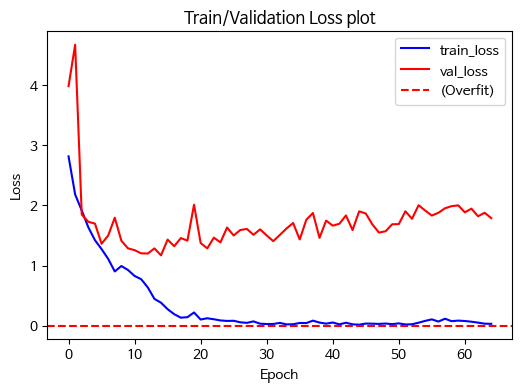

<Figure size 640x480 with 0 Axes>

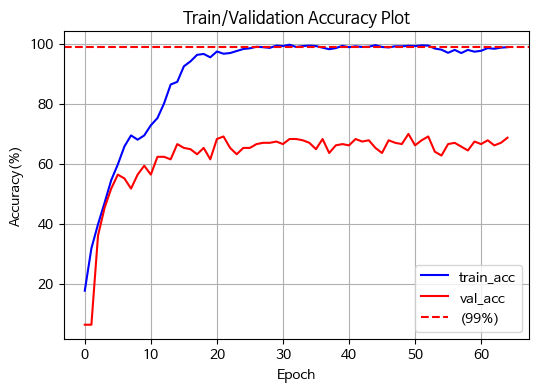

<Figure size 640x480 with 0 Axes>

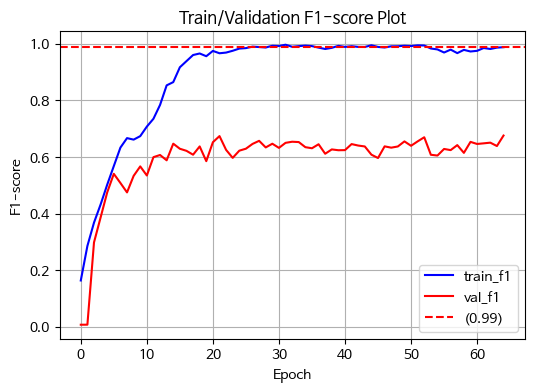

<Figure size 640x480 with 0 Axes>

In [26]:
# loss, accuracy, f1 plot 시각화 & wandb 저장
trainer.plot_loss(
    show=True,
    savewandb=True,
    savedir=None # 저장 안 함
)

In [104]:
display(pred_df[pred_df['ID']=='0a4f2decf34d3bff.jpg'])
display(pred_df[pred_df['ID']=='0a12d28777501f71.jpg'])
display(pred_df[pred_df['ID']=='0b60e9d39b43e0b9.jpg'])

,ID,target
111,0a4f2decf34d3bff.jpg,2


,ID,target
108,0a12d28777501f71.jpg,16


,ID,target
126,0b60e9d39b43e0b9.jpg,11


## 8. WandB Finish

In [27]:
run.finish()

train_accuracy,▁▄▄▅▅▆▆▇▇▇██████████████████████████████
train_f1,▁▂▄▄▅▅▅▆▆▇██████████████████████████████
train_loss,█▇▆▆▅▄▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▅▆▆▇▇▇▇▇█▇▇▇▇▇████████▇███▇█████▇████
val_f1,▁▁▆▆▇▇▇▇██▇████████████▇▇█▇▇████▇█▇▇████
val_loss,▇█▂▂▁▂▁▁▁▁▂▁▃▁▁▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▂▂
train_accuracy,98.8006
train_f1,0.98775
train_loss,0.03263
val_accuracy,68.64407
val_f1,0.67556


'resnetrs101.tf_in1k-opt_Adam-img224-aug_0-2507010210-0002'